In [1]:
import math # Mathematical functions 
import numpy as np # Fundamental package for scientific computing with Python
import pandas as pd # Additional functions for analysing and manipulating data
import matplotlib.dates as mdates # Formatting dates
import matplotlib.pyplot as plt # Important package for visualization - we use this to plot the market data
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error # Packages for measuring model performance / errors
from tensorflow.keras import Sequential # Deep learning library, used for neural networks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, Dense, Dropout,Activation # Deep learning classes for recurrent and regular densely-connected layers
from tensorflow.keras.callbacks import EarlyStopping # EarlyStopping during model training
from sklearn.preprocessing import MinMaxScaler # This Scaler removes the median and scales the data according to the quantile range to normalize the price data 
import seaborn as sns # Visualization
import plotly.graph_objects as go

# Import Data

In [2]:
def read_df(csv_file):
    df = pd.read_csv(csv_file)
    df["Date"]=pd.to_datetime(df["Date"])
    df.index=df["Date"]
    df.drop("Date",axis=1,inplace=True)
    return df
csv_file = "data\\NABIL_LARGE.csv"
df = read_df(csv_file)

In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-07-06,1261.0,1300.0,1300.0,1300.0,1300.0,100
2000-07-07,1300.0,1325.0,1301.0,1325.0,1325.0,356
2000-07-10,1325.0,1340.0,1340.0,1340.0,1340.0,25
2000-07-11,1340.0,1340.0,1340.0,1340.0,1340.0,370
2000-07-12,1340.0,1356.0,1355.0,1356.0,1356.0,517
...,...,...,...,...,...,...
2023-01-03,743.0,750.0,735.0,736.0,736.0,107994
2023-01-04,750.0,750.0,730.0,736.9,736.9,89872
2023-01-05,744.0,745.0,727.0,727.0,727.0,132642


# Exploring the data

(4928, 6)


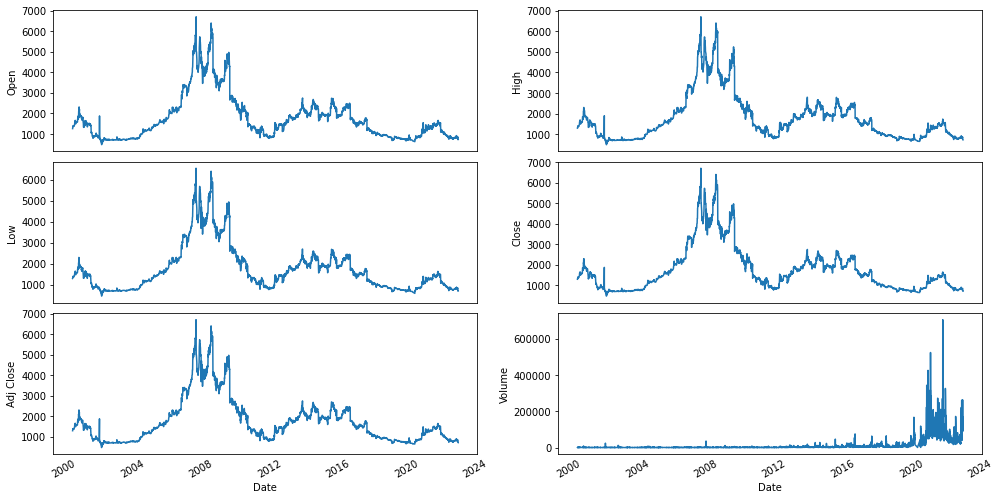

In [4]:
def plot_data(df):
    df_plot = df.copy()
    print(df_plot.shape)
    ncols = 2
    nrows = int(round(df_plot.shape[1] / ncols, 0))

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, figsize=(14, 7))
    for i, ax in enumerate(fig.axes):
            sns.lineplot(data = df_plot.iloc[:, i], ax=ax)
            ax.tick_params(axis="x", rotation=30, labelsize=10, length=0)
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    fig.tight_layout()
plt.show(plot_data(df)) 

In [5]:
# fig = go.Figure(data=[go.Candlestick(x=df.index,
#                 open=df['Open'], high=df['High'],
#                 low=df['Low'], close=df['Close'])])

# fig.update_layout(xaxis_rangeslider_visible=False)
# fig.show()

# Preprocessing and Feature Selection

In [6]:
def filter_data(df):
    
    # Indexing Batches
    train_df = df.sort_values(by=['Date']).copy()

    # List of considered Features
    FEATURES = ['Volume', 'High', 'Low', 'Open', 'Close'
            #, 'Month', 'Year', 'Adj Close'
               ]

    print('FEATURE LIST')
    print([f for f in FEATURES])

    # Create the dataset with features and filter the data to the list of FEATURES
    data = pd.DataFrame(train_df)
    data_filtered = data[FEATURES]
    return data_filtered
data_filtered = filter_data(df)
data_filtered

FEATURE LIST
['Volume', 'High', 'Low', 'Open', 'Close']


,Volume,High,Low,Open,Close
Date,,,,,
2000-07-06,100,1300.0,1300.0,1261.0,1300.0
2000-07-07,356,1325.0,1301.0,1300.0,1325.0
2000-07-10,25,1340.0,1340.0,1325.0,1340.0
2000-07-11,370,1340.0,1340.0,1340.0,1340.0
2000-07-12,517,1356.0,1355.0,1340.0,1356.0
...,...,...,...,...,...
2023-01-03,107994,750.0,735.0,743.0,736.0
2023-01-04,89872,750.0,730.0,750.0,736.9
2023-01-05,132642,745.0,727.0,744.0,727.0


# Train Test Split

In [7]:
def train_test_split(df):
    sequence_length = 100
    split_index = math.ceil(len(df) * 0.7)
    train_df = df.iloc[0:split_index, :]
    test_df = df.iloc[split_index - sequence_length:, :]
    return train_df, test_df,split_index


In [8]:
train_data, test_data, split = train_test_split(data_filtered)
test_data

,Volume,High,Low,Open,Close
Date,,,,,
2016-02-01,3476,1923.0,1892.0,1890.0,1905.0
2016-02-02,3778,1929.0,1890.0,1925.0,1900.0
2016-02-03,2036,1905.0,1894.0,1900.0,1900.0
2016-02-04,4192,1935.0,1905.0,1905.0,1917.0
2016-02-07,4515,1970.0,1930.0,1917.0,1935.0
...,...,...,...,...,...
2023-01-03,107994,750.0,735.0,743.0,736.0
2023-01-04,89872,750.0,730.0,750.0,736.9
2023-01-05,132642,745.0,727.0,744.0,727.0


In [9]:
def preprocess_data(data):
    # Get the number of rows in the data
    nrows = data.shape[0]

    # Convert the data to numpy values
    np_data_unscaled = np.array(data)
    np_data = np.reshape(np_data_unscaled, (nrows, -1))
    print(np_data.shape)

    # Transform the data by scaling each feature to a range between 0 and 1
    scaler = MinMaxScaler()
    np_data_scaled = scaler.fit_transform(np_data_unscaled)

#     # Creating a separate scaler that works on a single column for scaling predictions
#     scaler_pred = MinMaxScaler()
#     df_Close = pd.DataFrame(data_filtered['Close'])
#     np_Close_scaled = scaler_pred.fit_transform(df_Close)
    
    return np_data_scaled, scaler
train_data_scaled, scaler = preprocess_data(train_data)
test_data_scaled, scaler = preprocess_data(test_data)


(3450, 5)
(1578, 5)


# Partition dataset in x and y

In [10]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i,:]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

In [14]:
# Generate training data and test data
sequence_length = 100
x_train, y_train = partition_dataset(sequence_length, train_data_scaled)
x_test, y_test = partition_dataset(sequence_length, test_data_scaled)
# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
y_train[0]


(3350, 100, 5) (3350, 5)
(1478, 100, 5) (1478, 5)


array([0.01353558, 0.22258065, 0.23176955, 0.22656376, 0.2238302 ])

In [13]:
#validate_partition
print(x_train[1][sequence_length-1])
print(y_train[0])

[0.01353558 0.22258065 0.23176955 0.22656376 0.2238302 ]
[0.01353558 0.22258065 0.23176955 0.22656376 0.2238302 ]


# Build the LSTM MODEL

In [15]:
out = y_test.shape[1]
# define the model
model = Sequential()
model.add(LSTM(128, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(out))

# compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')


In [13]:
# fit the model to the training data
early_stop = EarlyStopping(monitor='val_loss', patience=5, mode='min')

history  = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop]
)

tf.keras.models.save_model(
    model,
    filepath = 'model\\my_model.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
    save_traces=True
)

Epoch 1/100
105/105 [==============================] - 17s 131ms/step - loss: 0.0450 - val_loss: 0.0030
Epoch 2/100
105/105 [==============================] - 14s 132ms/step - loss: 0.0040 - val_loss: 0.0022
Epoch 3/100
105/105 [==============================] - 13s 127ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 4/100
105/105 [==============================] - 13s 121ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 5/100
105/105 [==============================] - 13s 120ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 6/100
105/105 [==============================] - 13s 122ms/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/100
105/105 [==============================] - 13s 121ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 8/100
105/105 [==============================] - 13s 123ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/100
105/105 [==============================] - 13s 121ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 10/100
105/105 [==============================] - 13s 121m

# Training Vs Validation Loss

NameError: name 'history' is not defined

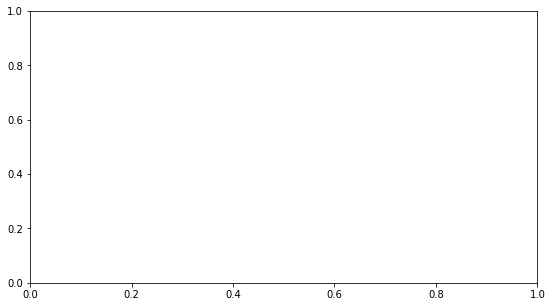

In [18]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history["loss"],label="Training Loss")
plt.plot(history.history["val_loss"],label="Validation Loss")
plt.legend(loc="upper right")
plt.xlabel("Epoch",fontsize=16)
plt.ylabel("Loss",fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title("Training and Validation Loss",fontsize=16)
plt.show()

In [15]:
### Lets Do the prediction and check performance metrics
# train_predict=model.predict(x_train)
test_predict=model.predict(x_test)


In [16]:
##Transformback to original form
# train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)
y_test_unscaled = scaler.inverse_transform(y_test)
test_predict.shape

(1478, 5)

# Evaluate the Performance

In [17]:
i = 3
#Root Mean Square Error(RMSE)
RMSE = math.sqrt(mean_squared_error(y_test_unscaled[:, i],test_predict[:, i]))
print(f'Root Mean Square Error(RMSE): {np.round(RMSE, 2)}')

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled[:, i],test_predict[:, i])
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled[:, i],test_predict[:, i])/ y_test_unscaled[:, i]))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled[:, i],test_predict[:, i])/ y_test_unscaled[:, i])) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')

Root Mean Square Error(RMSE): 42.4
Median Absolute Error (MAE): 24.06
Mean Absolute Percentage Error (MAPE): 2.09 %
Median Absolute Percentage Error (MDAPE): 1.26 %


In [18]:
Train = df[:split]
valid = df[split:]
valid['Predictions'] = test_predict[:, 3]
valid

C:\Users\MSI-1\AppData\Local\Temp\ipykernel_5616\2502017022.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = test_predict[:, 3]


,Open,High,Low,Close,Adj Close,Volume,Predictions
Date,,,,,,,
2016-07-03,2410.0,2404.0,2389.0,2400.0,2400.0,7898,2384.129883
2016-07-04,2400.0,2400.0,2380.0,2395.0,2395.0,5504,2361.416016
2016-07-05,2395.0,2400.0,2371.0,2380.0,2380.0,9924,2373.500000
2016-07-06,2390.0,2399.0,2370.0,2375.0,2375.0,7384,2380.533691
2016-07-10,2375.0,2408.0,2382.0,2395.0,2395.0,12007,2370.338623
...,...,...,...,...,...,...,...
2023-01-03,743.0,750.0,735.0,736.0,736.0,107994,854.983032
2023-01-04,750.0,750.0,730.0,736.9,736.9,89872,817.233154
2023-01-05,744.0,745.0,727.0,727.0,727.0,132642,778.269043


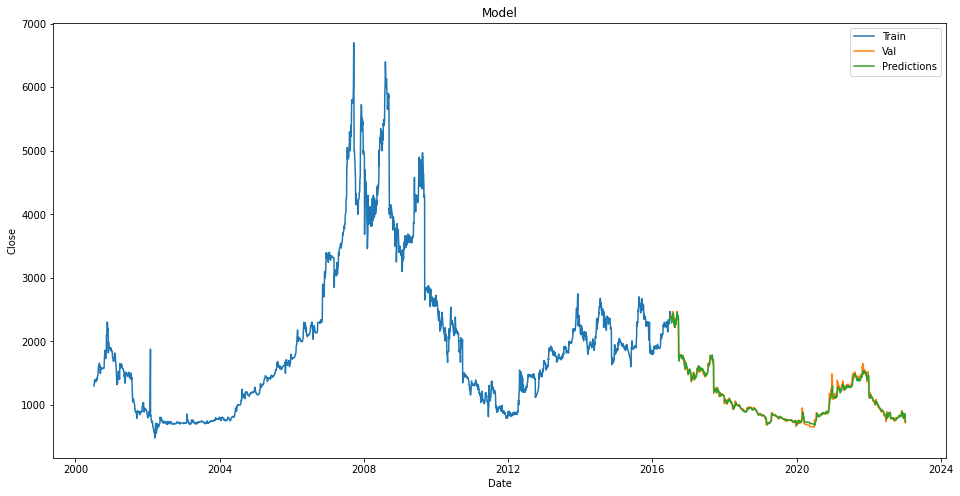

In [19]:
plt.figure(figsize=(16,8 ))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close')
 
plt.plot(Train['Close'])
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
 
plt.legend(['Train', 'Val', 'Predictions'], loc='upper right')
 
plt.show()

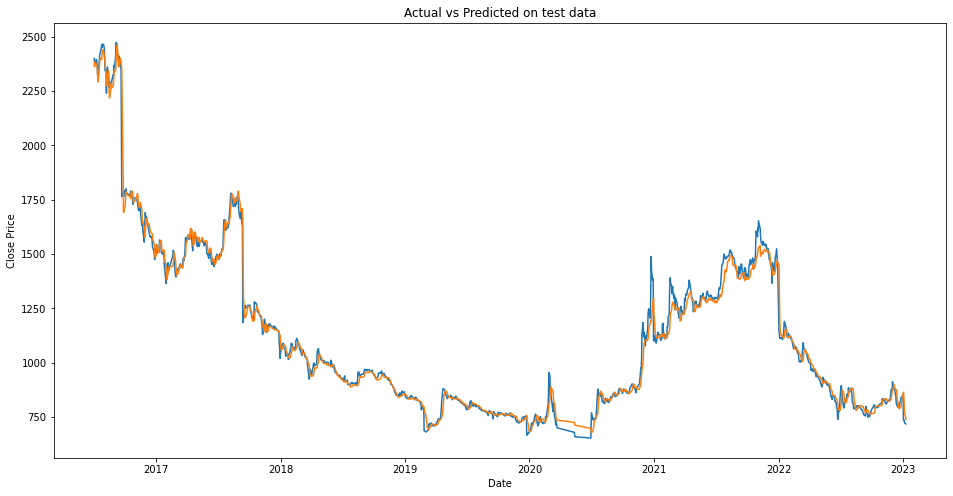

In [235]:
plt.figure(figsize=(16,8))
plt.title("Actual vs Predicted on test data")
plt.plot(valid['Close'])
plt.plot(valid['Predictions'])
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.show()

In [20]:
new_df_csv = "data\\NABIL_LARGE.csv"
new_df = read_df(new_df_csv)
new_df 

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-07-06,1261.0,1300.0,1300.0,1300.0,1300.0,100
2000-07-07,1300.0,1325.0,1301.0,1325.0,1325.0,356
2000-07-10,1325.0,1340.0,1340.0,1340.0,1340.0,25
2000-07-11,1340.0,1340.0,1340.0,1340.0,1340.0,370
2000-07-12,1340.0,1356.0,1355.0,1356.0,1356.0,517
...,...,...,...,...,...,...
2023-01-03,743.0,750.0,735.0,736.0,736.0,107994
2023-01-04,750.0,750.0,730.0,736.9,736.9,89872
2023-01-05,744.0,745.0,727.0,727.0,727.0,132642


(4928, 6)


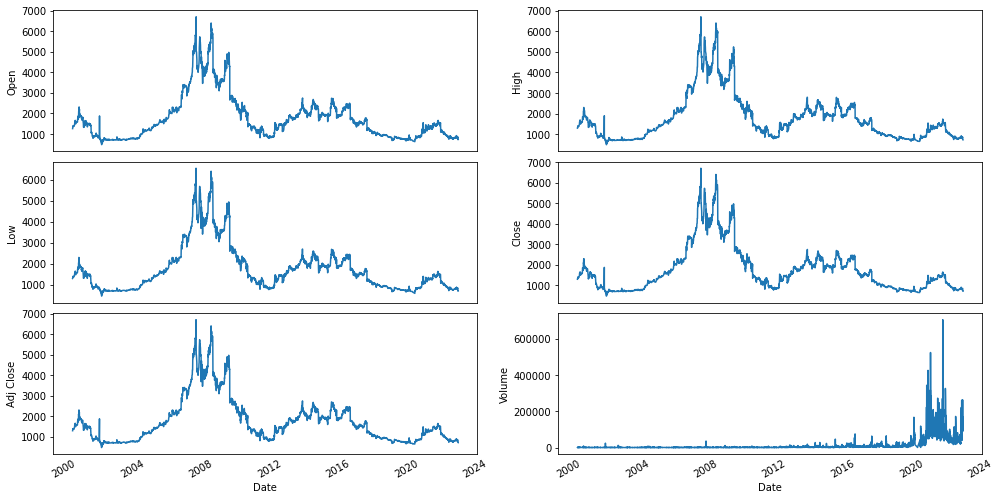

In [21]:
plt.show(plot_data(new_df))

In [103]:
new_data_filtered = filter_data(new_df)
new_data_filtered

FEATURE LIST
['Volume', 'High', 'Low', 'Open', 'Close']


,Volume,High,Low,Open,Close
Date,,,,,
2000-07-06,100,1300.0,1300.0,1261.0,1300.0
2000-07-07,356,1325.0,1301.0,1300.0,1325.0
2000-07-10,25,1340.0,1340.0,1325.0,1340.0
2000-07-11,370,1340.0,1340.0,1340.0,1340.0
2000-07-12,517,1356.0,1355.0,1340.0,1356.0
...,...,...,...,...,...
2023-01-03,107994,750.0,735.0,743.0,736.0
2023-01-04,89872,750.0,730.0,750.0,736.9
2023-01-05,132642,745.0,727.0,744.0,727.0


In [227]:
new_data_scaled, scaler = preprocess_data(new_data_filtered)

(4928, 5)


In [228]:
sequence_length = 100
x, y = partition_dataset(sequence_length, new_data_scaled)
x.shape

(4828, 100, 5)

In [229]:
#validate_partition
print(x[1][sequence_length-1])
print(y[0])

[0.00089307 0.22258065 0.23176955 0.22656376 0.2238302 ]
[0.00089307 0.22258065 0.23176955 0.22656376 0.2238302 ]


In [230]:
len(new_data_scaled)
new_data_scaled[-sequence_length]

array([0.05290965, 0.06116129, 0.06337449, 0.06402959, 0.0593343 ])

In [231]:
n_steps = sequence_length
x_input = new_data_scaled[-n_steps:, :]
x_input = x_input.reshape((1, n_steps, x.shape[2]))


In [232]:
# yhat = model.predict(x_input, verbose=0)
# yhat = yhat.reshape((1, 1, yhat.shape[1]))
# yhat.shape

In [233]:
# Initialize an empty list to store the predictions
lst_output = []

# Loop for 30 days
forecast = 30
for i in range(forecast):
    # Make a prediction
    yhat = model.predict(x_input, verbose=0)
    # Append the prediction to the list
    lst_output.append(yhat[0])
    yhat = yhat.reshape((1, 1, yhat.shape[1]))
    # Update x_input with the last 100 input and the previous prediction
    x_input = np.concatenate((x_input[:,1:,:], yhat), axis = 1)
    # Keep only the last 100 input for the next prediction
#     x_input = x_input[-sequence_length:, :]


In [234]:
lst_output = scaler.inverse_transform(lst_output)
lst_output_close = lst_output[:,-1]
lst_output_close

array([516.52102653, 513.98267059, 509.80473629, 504.97186898,
       500.02039524, 495.44829353, 491.4800186 , 488.20820964,
       485.50179281, 483.38514855, 481.80220924, 480.67182082,
       479.90454359, 479.41929862, 479.15091016, 479.04329603,
       479.05096269, 479.13201121, 479.26239962, 479.41996125,
       479.59014848, 479.76112649, 479.92568898, 480.07913221,
       480.22045979, 480.34730953, 480.45885374, 480.55541802,
       480.63795124, 480.70816224])

In [226]:
dataset = new_data_filtered.filter(['Close'])
dataset


,Close
Date,
2000-07-06,1300.0
2000-07-07,1325.0
2000-07-10,1340.0
2000-07-11,1340.0
2000-07-12,1356.0
...,...
2023-01-03,736.0
2023-01-04,736.9
2023-01-05,727.0


                 Close
2023-01-10  698.770900
2023-01-11  673.024119
2023-01-12  637.359946
2023-01-13  605.422046
2023-01-14  580.819373
2023-01-15  563.825027
2023-01-16  553.226322
2023-01-17  547.513104
2023-01-18  545.416067
2023-01-19  545.983673
2023-01-20  548.510051
2023-01-21  552.475136
2023-01-22  557.513158
2023-01-23  563.365752
2023-01-24  569.795219
2023-01-25  576.609453
2023-01-26  583.643223
2023-01-27  590.767625
2023-01-28  597.881833
2023-01-29  604.913286
2023-01-30  611.814260
2023-01-31  618.554636
2023-02-01  625.117826
2023-02-02  631.495119
2023-02-03  637.683829
2023-02-04  643.684325
2023-02-05  649.502724
2023-02-06  655.155613
2023-02-07  660.650315
2023-02-08  665.991276


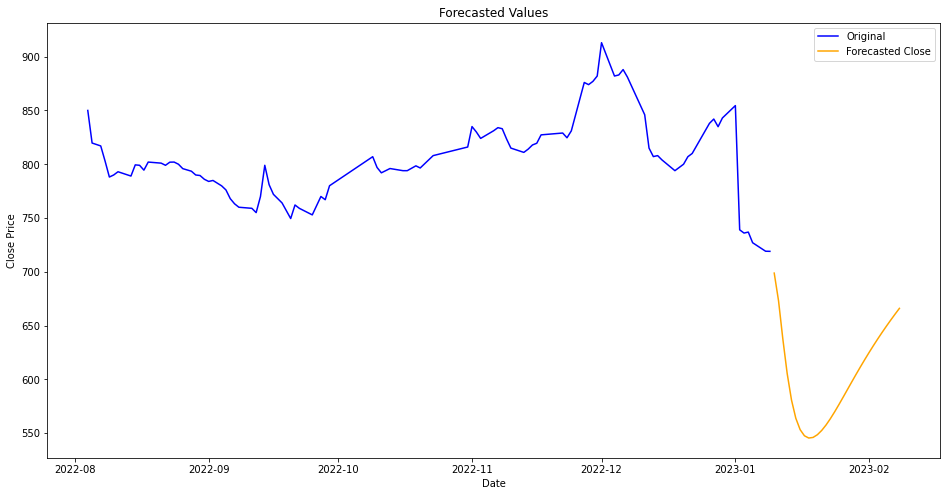

In [162]:
# Use pandas to concatenate the forecasted values to the last of the dataset
forecasted_values = pd.DataFrame(lst_output_close, columns=['Close'])
original_data_length = len(dataset)
index = pd.date_range(start=dataset.index[-1] + pd.DateOffset(1), periods=forecast, freq="D")
forecasted_values.set_index(index,inplace=True)
print(forecasted_values)
dataset = pd.concat([dataset, forecasted_values], axis=0)

plt.figure(figsize=(16,8))
plt.plot(dataset.index[-sequence_length-forecast:-forecast], dataset['Close'][-sequence_length-forecast:-forecast], 'b', label='Original')
plt.plot(dataset.index[-forecast:], dataset['Close'][-forecast:], 'orange', label='Forecasted Close')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Forecasted Values')
plt.show()

